In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sartorius-cell-instance-segmentation/sample_submission.csv
/kaggle/input/sartorius-cell-instance-segmentation/train.csv
/kaggle/input/sartorius-cell-instance-segmentation/LIVECell_dataset_2021/annotations/LIVECell_single_cells/shsy5y/livecell_shsy5y_train.json
/kaggle/input/sartorius-cell-instance-segmentation/LIVECell_dataset_2021/annotations/LIVECell_single_cells/shsy5y/livecell_shsy5y_val.json
/kaggle/input/sartorius-cell-instance-segmentation/LIVECell_dataset_2021/annotations/LIVECell_single_cells/shsy5y/livecell_shsy5y_test.json
/kaggle/input/sartorius-cell-instance-segmentation/LIVECell_dataset_2021/annotations/LIVECell_single_cells/skov3/livecell_skov3_test.json
/kaggle/input/sartorius-cell-instance-segmentation/LIVECell_dataset_2021/annotations/LIVECell_single_cells/skov3/livecell_skov3_train.json
/kaggle/input/sartorius-cell-instance-segmentation/LIVECell_dataset_2021/annotations/LIVECell_single_cells/skov3/livecell_skov3_val.json
/kaggle/input/sartorius-cell-ins

In [2]:
# !pip install torchsummary
import torch
import torch.nn as nn
import albumentations as A
import torch.optim as optim
import pandas as pd
import os
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import random
# import torchsummary
from sklearn.metrics import f1_score
from tqdm import tqdm
import skimage.morphology

In [3]:
# hyperparameters
PATH = "/kaggle/input/sartorius-cell-instance-segmentation"
IMAGE_HEIGHT = 520
IMAGE_WIDTH = 704
IMAGE_NEW_HEIGHT = 352
IMAGE_NEW_WIDTH = 352
LEARNING_RATE = 0.01
EPOCHS = 250
BATCH_SIZE = 16
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
#loading data
df = pd.read_csv(os.path.join(PATH, "train.csv"))
df

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
...,...,...,...,...,...,...,...,...,...
73580,ffdb3cc02eef,3610 3 4311 7 5014 9 5717 11 6420 13 7123 15 7...,704,520,cort,11h59m00s,2020-11-01,cort[debris]_D9-3_Vessel-384_Ph_4,0 days 11:59:00
73581,ffdb3cc02eef,341585 2 342287 5 342988 10 343690 13 344394 1...,704,520,cort,11h59m00s,2020-11-01,cort[debris]_D9-3_Vessel-384_Ph_4,0 days 11:59:00
73582,ffdb3cc02eef,47788 3 48490 7 49192 11 49896 13 50599 14 513...,704,520,cort,11h59m00s,2020-11-01,cort[debris]_D9-3_Vessel-384_Ph_4,0 days 11:59:00
73583,ffdb3cc02eef,333290 1 333993 2 334696 4 335399 5 336102 6 3...,704,520,cort,11h59m00s,2020-11-01,cort[debris]_D9-3_Vessel-384_Ph_4,0 days 11:59:00


In [5]:
images = glob.glob(os.path.join(PATH , "train/*" ))
test_images = glob.glob(os.path.join(PATH,"test/*"))
random.shuffle(images)
train_images = images[:int(len(images)*0.95)]
val_images = images[int(len(images)*0.95) : ]
    

In [6]:
def show(image,mask):
    if(type(image) == torch.Tensor):
        image= image.permute(1,2,0)
        mask = mask.permute(1,2,0)
    plt.figure(figsize=(40,40))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask)
    plt.figure(figsize=(40,40))
    plt.imshow(image)
    plt.imshow(mask,alpha = 0.2)

In [7]:
transform = A.Compose(
    [
    A.Resize(height = IMAGE_NEW_HEIGHT , width = IMAGE_NEW_WIDTH),
    A.Normalize(mean=(0.485, 0.456, 0.406), std= (0.229, 0.224, 0.225), p=1),
    A.Rotate(limit=35, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
     ]
)
transform_test = A.Compose(
    [
    A.Resize(height = 512 , width = 720),
    A.Normalize(mean=(0.485, 0.456, 0.406), std= (0.229, 0.224, 0.225), p=1),
     ]
)
transform_test_reverse = A.Compose(
    [
    A.Resize(height = IMAGE_HEIGHT , width = IMAGE_WIDTH),
    ]
)

In [8]:
class Custom_Dataset(Dataset):
    
    def __init__(self,df,images,transform=None,train = False):
        
        self.images =  images
        self.df = df
        self.transform = transform
        self.train = train
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,index):
        
        path = self.images[index]    
        img = cv2.imread(path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        self.image_id = self.images[index].split('/')[-1].split(".")[0]
        
        img_mask = self.compute()
        img_mask = img_mask.astype('float32')

        if (self.transform != None):
            augmentation = self.transform(image = img , mask = img_mask)
            img = augmentation["image"]
            img_mask = augmentation["mask"]
            
            
        img = torch.tensor(img).to(torch.float)
        img = img.permute(2,0,1) 
       
        img_mask = torch.tensor(img_mask).to(torch.float).unsqueeze(0)
        return img,img_mask
    
    def compute(self):
        mask = np.zeros((IMAGE_HEIGHT * IMAGE_WIDTH))
        for i in list(df[df["id"] == self.image_id]["annotation"]):
            for index,j in enumerate(i.split()):
                if(index % 2 == 0):
                    x = int(j)
                else:
                    mask[x:x+int(j)] = 1
        return mask.reshape(IMAGE_HEIGHT,IMAGE_WIDTH)

In [9]:
def load_dataset():
    
    train_data = Custom_Dataset(df,train_images,transform,True)
    val_data = Custom_Dataset(df,val_images,transform,True)
    
    train_loader = DataLoader(train_data,batch_size = BATCH_SIZE, shuffle = True)
    val_loader  = DataLoader(val_data , batch_size = len(val_data))
    
    return train_loader , val_loader

In [10]:
train_loader , val_loader = load_dataset()

In [11]:
m,q = next(iter(train_loader))
m.shape

torch.Size([16, 3, 352, 352])

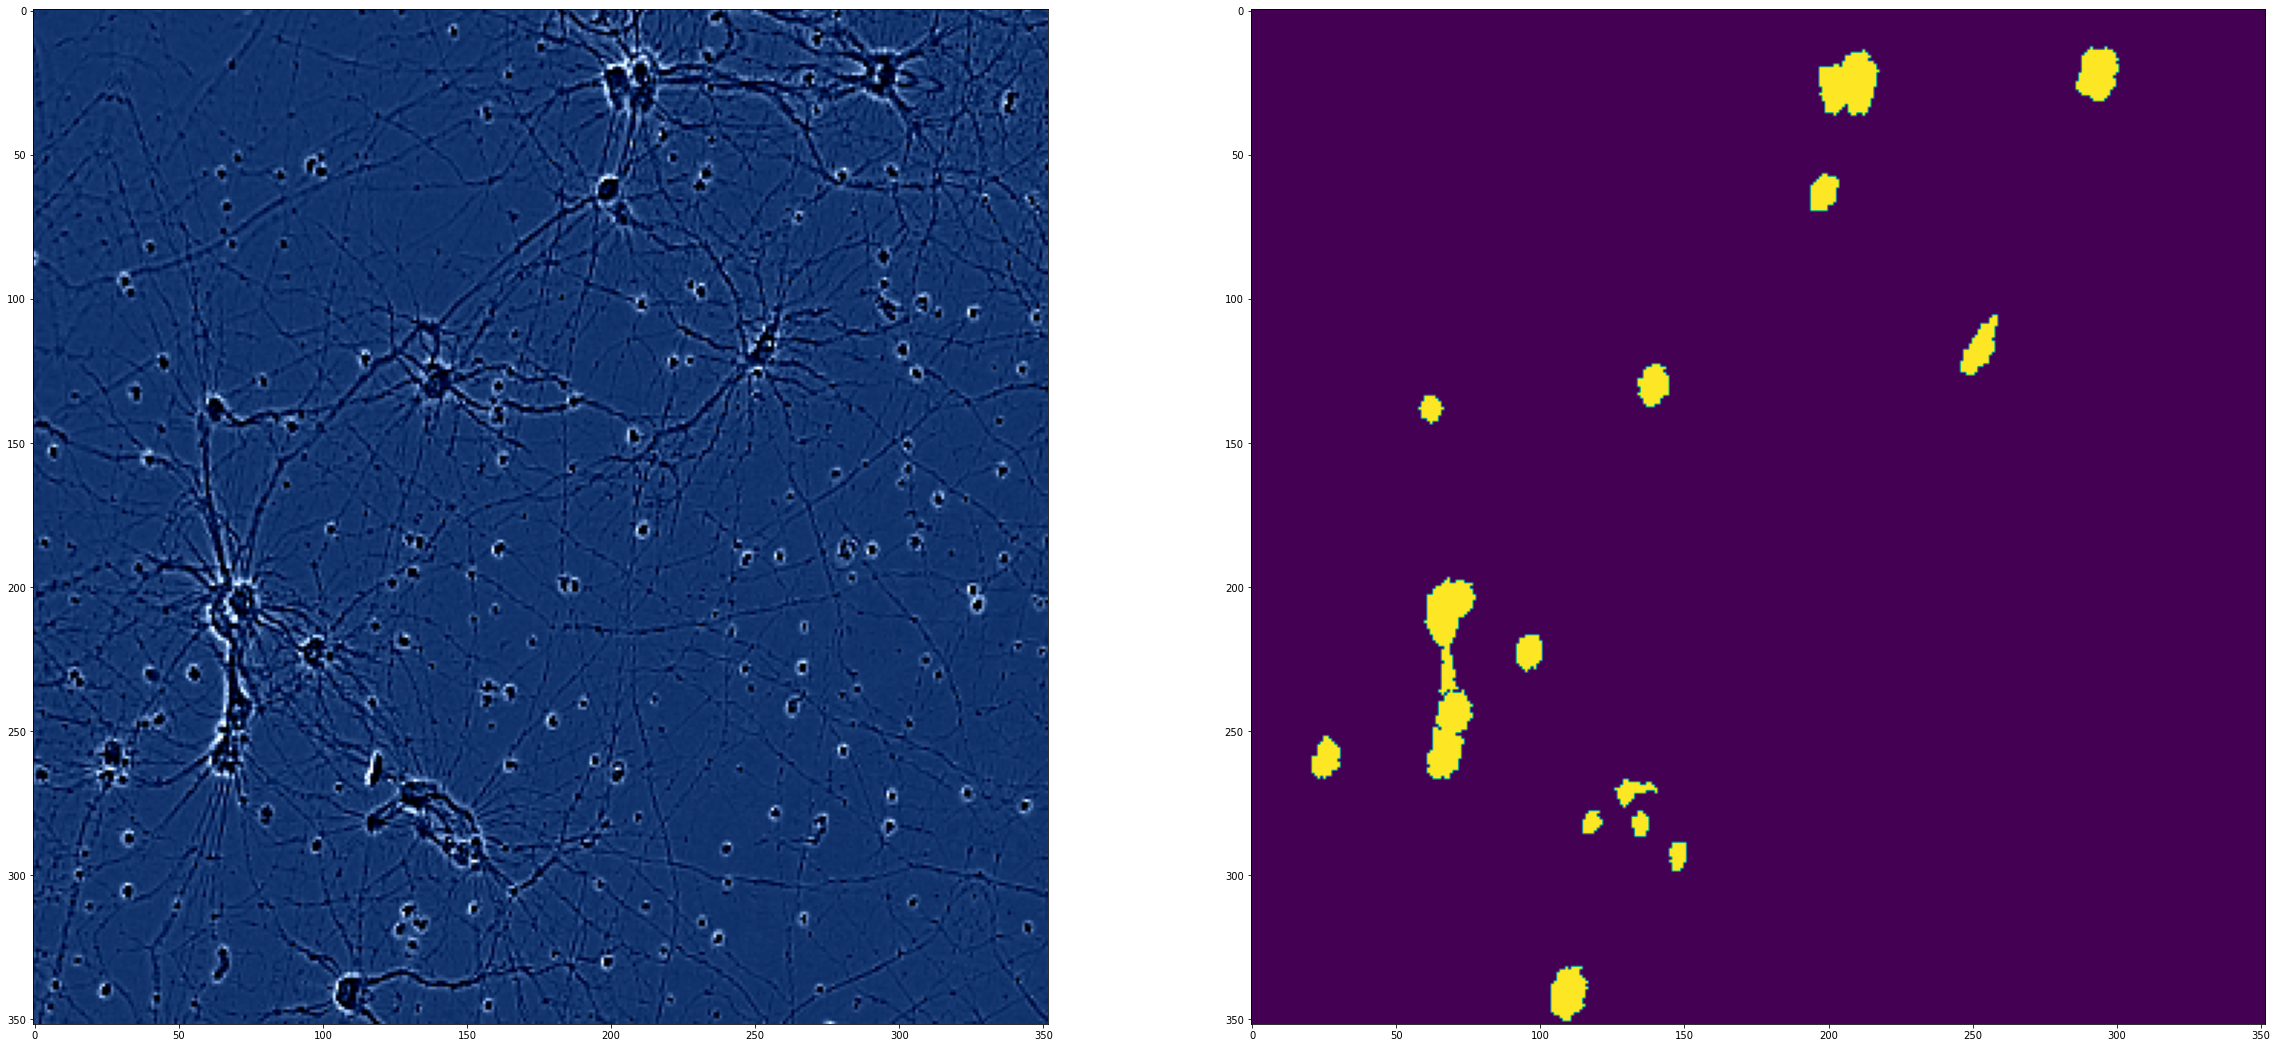

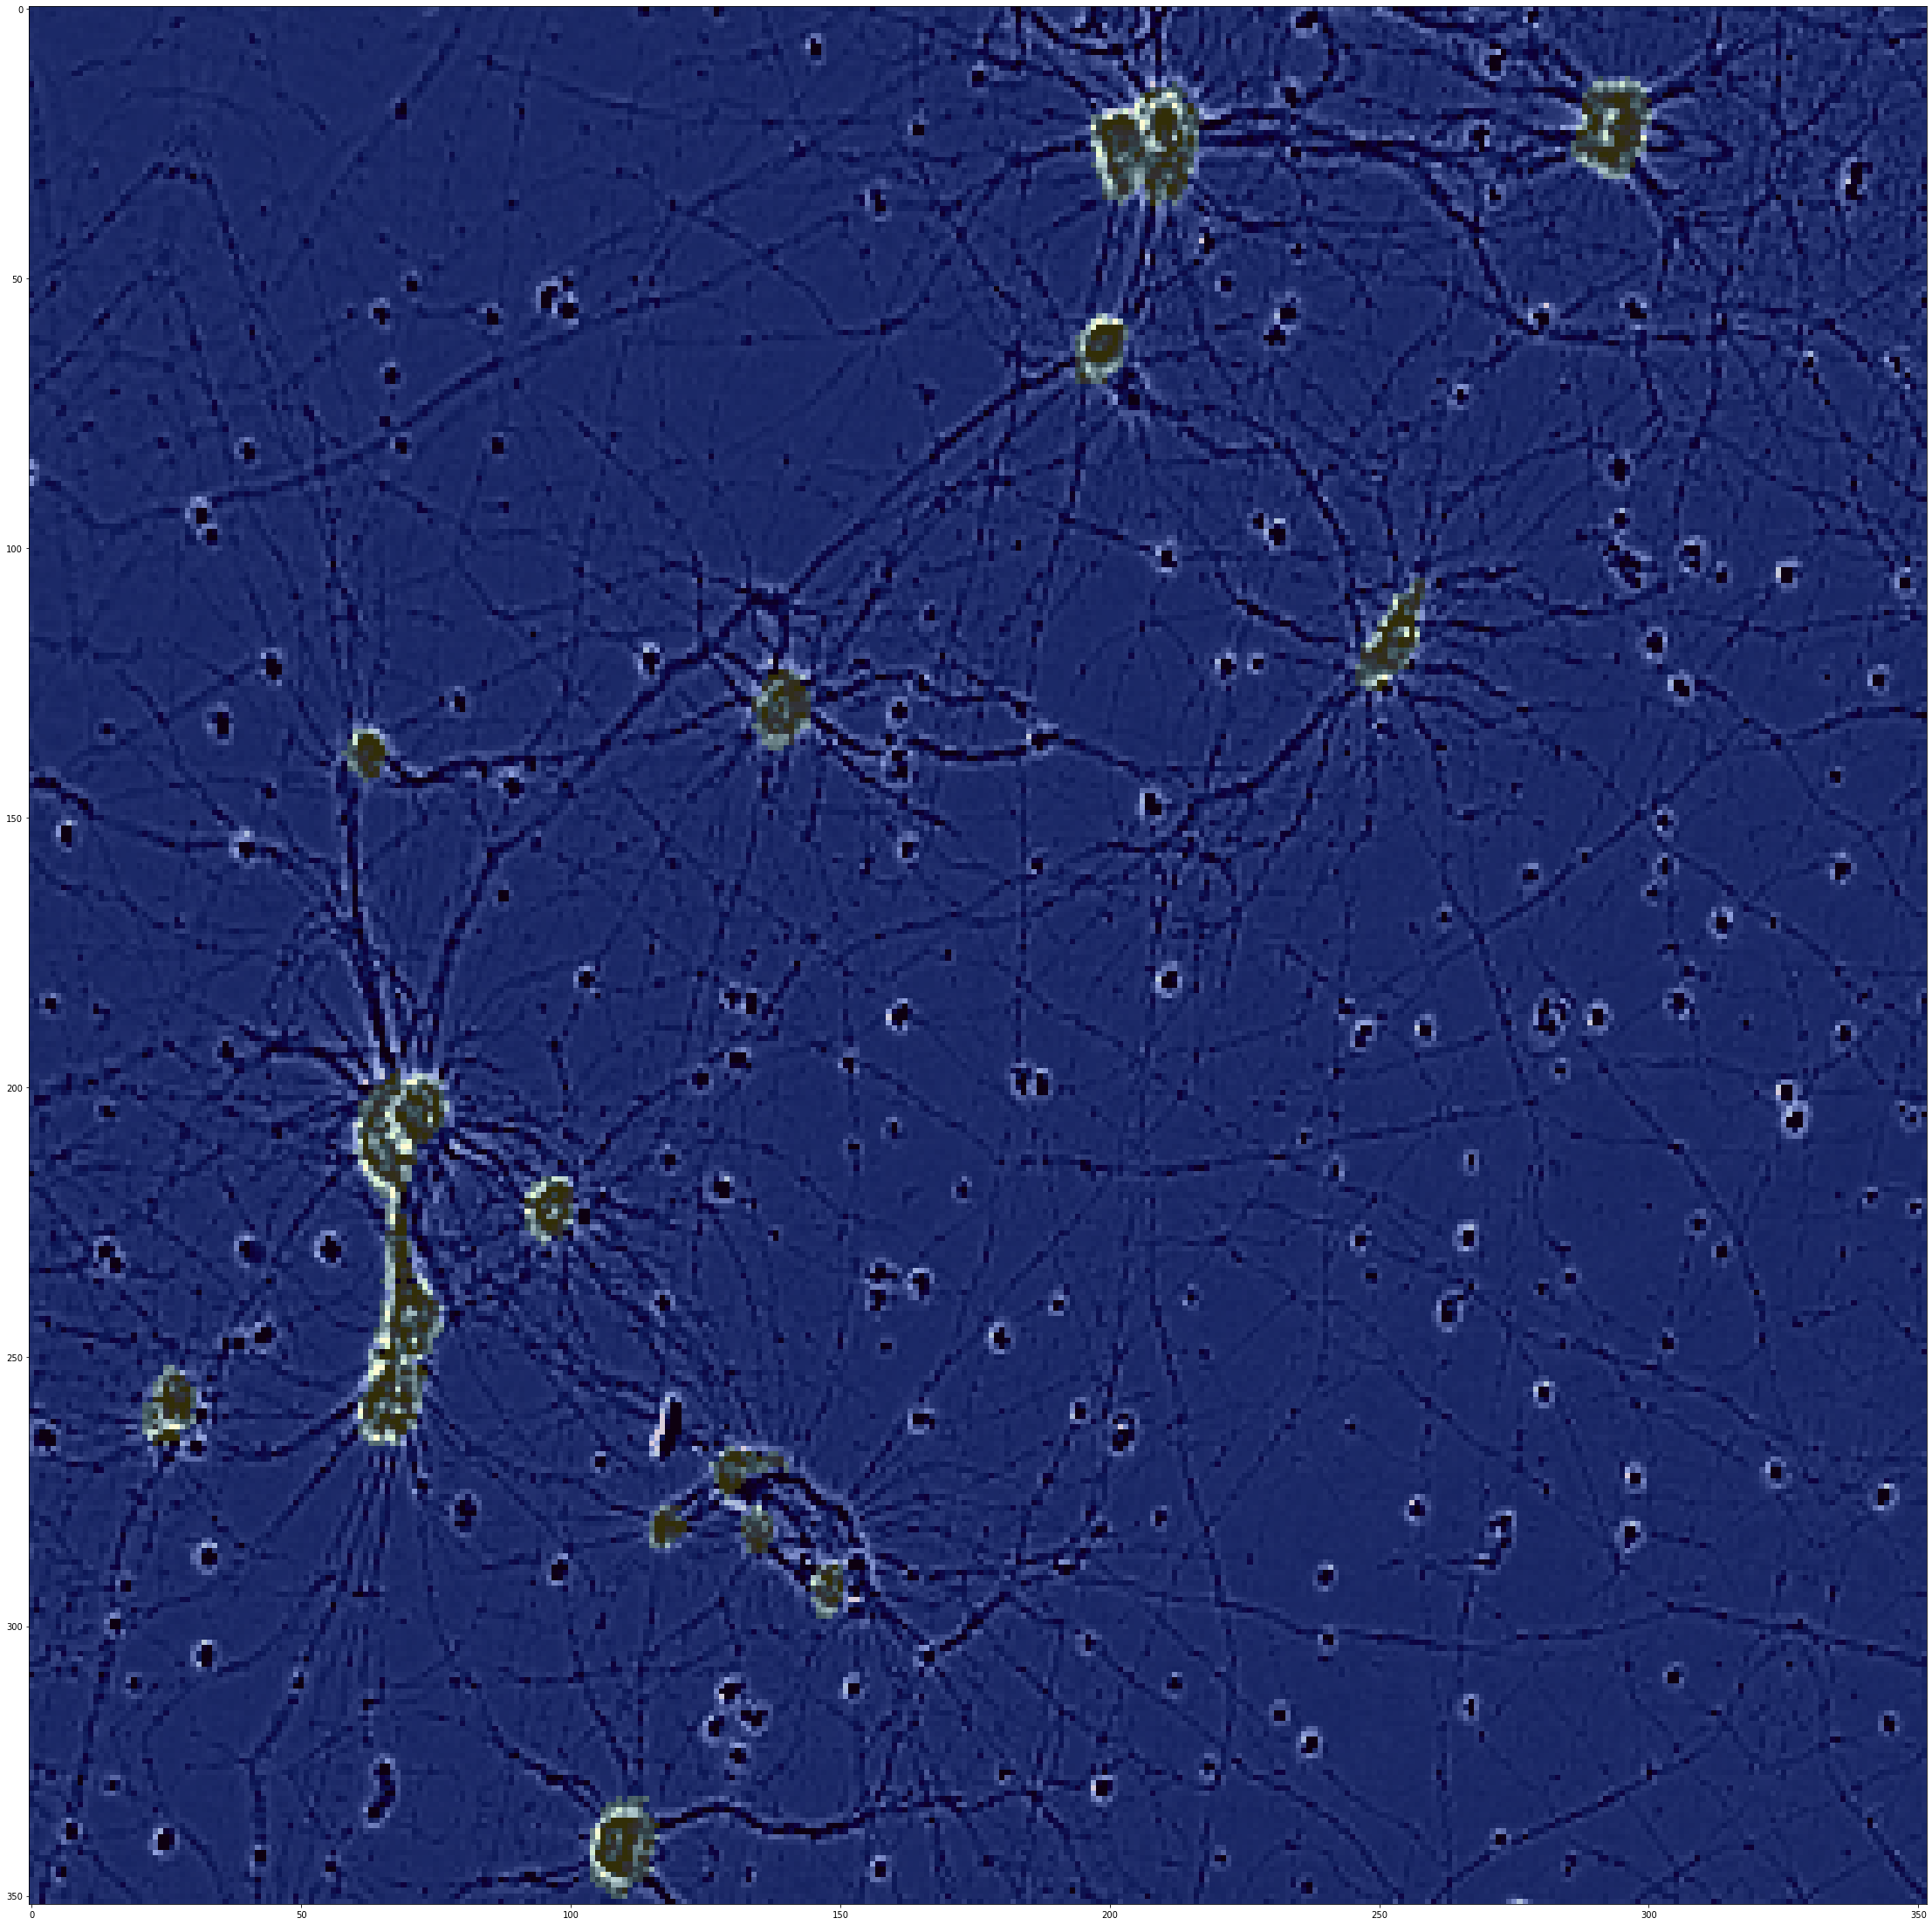

In [12]:
show(m[0],q[0])

In [13]:
class Double_Convolution(nn.Module):
    
    def __init__(self,in_channels , out_channels , kernel_size, padding):
        
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels,out_channels, kernel_size , padding  = padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            
            nn.Conv2d(out_channels,out_channels, kernel_size , padding  = padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    def forward(self,x):
        return self.double_conv(x)

In [14]:
class UNET(nn.Module):
    
    def __init__(self,in_channels,features = [64,128, 256,512,1024],kernel_size = 3 , padding = 1, kernel_size_up = 2,stride_up = 2):
        
        super().__init__()
        
        #down
        self.down1 = Double_Convolution(in_channels, features[0] , kernel_size , padding)
        self.down2 = Double_Convolution(features[0], features[1] , kernel_size , padding)
        self.down3 = Double_Convolution(features[1], features[2] , kernel_size , padding)
        self.down4 = Double_Convolution(features[2], features[3] , kernel_size , padding)
        self.down5 = Double_Convolution(features[3], features[4] , kernel_size , padding)
        
        self.maxpool = nn.MaxPool2d(2)
        
        #up
        
        self.up1 = nn.ConvTranspose2d(features[4],features[3],kernel_size_up, stride =2)
        self.same1 = Double_Convolution(features[4],features[3],kernel_size , padding)
        
        self.up2 = nn.ConvTranspose2d(features[3],features[2],kernel_size_up, stride = 2)
        self.same2 = Double_Convolution(features[3],features[2],kernel_size , padding)
        
        self.up3 = nn.ConvTranspose2d(features[2],features[1],kernel_size_up, stride = 2)
        self.same3 = Double_Convolution(features[2],features[1],kernel_size , padding)
        
        self.up4 = nn.ConvTranspose2d(features[1],features[0],kernel_size_up, stride = 2)
        self.same4 = Double_Convolution(features[1],features[0],kernel_size , padding)
        
        self.out = nn.Conv2d(features[0],1,kernel_size,padding= padding)
        
        self.next_out = nn.Sigmoid()
        
    def forward(self,x):
        
        #going down
        
        d1 = self.down1(x)
        d2 = self.maxpool(d1)
        
        d2 = self.down2(d2)
        d3 = self.maxpool(d2)
        
        d3 = self.down3(d3)
        d4 = self.maxpool(d3)
        
        d4 = self.down4(d4)
        d5 = self.maxpool(d4)
        
        d5 = self.down5(d5)
        
        #going up
        
        z1 = self.up1(d5)
      
        z1 = torch.cat((z1 ,d4), 1)
        z1 = self.same1(z1)
        
        z1 = self.up2(z1)
        z1 = torch.cat((z1 ,d3), 1)
        z1 = self.same2(z1)
        
        z1 = self.up3(z1)
        z1 = torch.cat((z1 ,d2), 1)
        z1 = self.same3(z1)
        
        z1 = self.up4(z1)
        z1 = torch.cat((z1 ,d1), 1)
        z1 = self.same4(z1)
        
        z1 = self.out(z1)
        z1 = self.next_out(z1)
        
        return z1

In [15]:
model = UNET(3,padding = 1).to(device =DEVICE)
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(),lr = LEARNING_RATE)
# torchsummary.summary(model,(3,256,256))

In [16]:
def train_model():
    model.train()
    losses = []
    for index,(data,target) in enumerate(train_loader):

        data = data.to(device = DEVICE)
        target = target.to(device = DEVICE)
         
        prediction = model(data)
        loss = loss_fn(prediction,target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    return (sum(losses)/len(losses))

In [17]:
train_model()

0.28621992137697005

In [18]:
def evaluate(threshold):
    model.eval()
    with torch.no_grad():
        f1s= []
        loss = []
        accuracies = []
        for(x,y) in val_loader:
            x = x.to(device = DEVICE)
            y = y.to(device = DEVICE)
            
            prediction = model(x)
            losses = loss_fn(prediction,y)
            loss.append(losses)
            
            prediction  = (prediction >=threshold).int()
            
            prediction_new = prediction.view(-1).cpu().numpy()
            y_new = y.view(-1).int().cpu().numpy()
            
            accuracies.append( ((prediction_new== y_new).sum()) /len(prediction_new))
    
            f1  = f1_score(y_new,prediction_new)
            
            union = np.where(y_new+ prediction_new,1,0).sum()
            intersection = y_new.sum() + prediction_new.sum() - union
            f1s.append(f1)
            
    return (sum(accuracies).item()/len(accuracies) , sum(f1s)/len(f1s) , (intersection/union).item() , sum(loss).item()/len(loss) ) 

In [19]:
evaluate(0.5)

(0.9133108775159957,
 0.23924988519350318,
 0.13587952269978773,
 0.42847251892089844)

In [20]:
loss_plot_train = []
loss_plot_val = []
accuracy_plot = []
f1_plot = []
iou_plot = []

In [21]:
def training():
    with tqdm(total=EPOCHS, position=0, leave=True) as pbar:
        for epoch in range(EPOCHS):
            loss = train_model()
            loss_plot_train.append(loss)
            accuracy, f1,iou,l1  = evaluate(0.5)
            accuracy_plot.append(accuracy)
            f1_plot.append(f1)
            pbar.update()
            iou_plot.append(iou)
            loss_plot_val.append(l1)
            pbar.set_postfix(loss = (loss,l1) , acc = (accuracy,f1,iou ) )

In [22]:
training()

100%|██████████| 250/250 [4:08:24<00:00, 59.62s/it, acc=(0.943978220391229, 0.6369325515670476, 0.4672788219682716), loss=(0.10947122859458129, 0.13719141483306885)]


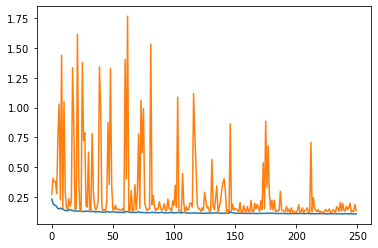

In [23]:
plt.plot(loss_plot_train , label = "train loss")
plt.plot(loss_plot_val, label = "val loss")

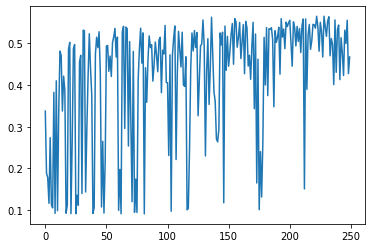

In [24]:
plt.plot(iou_plot)

In [25]:
#inference
threshold = 0.5
test_id = [index.split("/")[-1].split(".")[0] for index in test_images]
final = pd.DataFrame(test_id,columns=["id"])
final

,id
0,7ae19de7bc2a
1,d8bfd1dafdc4
2,d48ec7815252


In [26]:
def mask2rle(mask):
    mask = np.array(mask)
    pixels = mask.flatten()
    pad = np.array([0])
    pixels = np.concatenate([pad, pixels, pad])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [27]:
def mask2rle(mask):
    mask = np.array(mask)
    pixels = mask.flatten()
    pad = np.array([0])
    pixels = np.concatenate([pad, pixels, pad])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def mask2rle_list(mask, cutoff=0.5, min_object_size=1.0):
    """ Return run length encoding of mask.
        ref: https://www.kaggle.com/raoulma/nuclei-dsb-2018-tensorflow-u-net-score-0-352
    """
    # segment image and label different objects
    lab_mask = skimage.morphology.label(mask > cutoff)

    # Keep only objects that are large enough.
    (mask_labels, mask_sizes) = np.unique(lab_mask, return_counts=True)
    l = (mask_sizes < min_object_size).any()
    if (mask_sizes < min_object_size).any():
        mask_labels = mask_labels[mask_sizes < min_object_size]
        for n in mask_labels:
            lab_mask[lab_mask == n] = 0
        lab_mask = skimage.morphology.label(lab_mask > cutoff)

        # Loop over each object excluding the background labeled by 0.
    for i in range(1, lab_mask.max() + 1):
        yield mask2rle(lab_mask == i)

In [28]:
final= {"id" : [] , "predicted" : []}

In [29]:
for index,i in enumerate(test_images):
    image = cv2.imread(i)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image_id = i.split('/')[-1].split(".")[0]
    augmentation = transform_test(image = image)
    image = augmentation["image"]
    image =torch.tensor(image).to(device = DEVICE).permute(2,0,1).unsqueeze(0).float()
    prediction = model(image)
    
    prediction = prediction.squeeze(0).permute(1,2,0).detach().cpu().numpy()
#     plt.imshow( (prediction>0.5 ).astype("int") )
    prediction = cv2.resize(prediction , (IMAGE_WIDTH,IMAGE_HEIGHT), interpolation = cv2.INTER_AREA)
    prediction = (prediction>=threshold).astype("int")
#     k = mask2rle(prediction)
#     final["id"].append(image_id)
#     final["predicted"].append(k)
    
    m = list(mask2rle_list(prediction))
    for i in m:
        final["id"].append(image_id)
        final["predicted"].append(i)
    

In [30]:
result = pd.DataFrame(final)
result

,id,predicted
0,7ae19de7bc2a,47 6 63 11 751 6 765 12 1455 26 2160 24 2864 2...
1,7ae19de7bc2a,133 23 842 19 1547 18 2252 18 2956 18 3660 9 3...
2,7ae19de7bc2a,185 6 890 4 1594 4 2299 3 3003 2 3708 1 4412 1
3,7ae19de7bc2a,203 3 908 3 1612 3 2316 3 3020 4 3725 4 4429 3...
4,7ae19de7bc2a,274 6 979 6 1684 8 2389 9 3094 11 3798 13 4503...
...,...,...
438,d48ec7815252,359555 4 360258 7 360961 9 361663 13 362366 18...
439,d48ec7815252,363436 1 364140 3 364845 2 365549 2
440,d48ec7815252,363989 3 364692 3 365396 3
441,d48ec7815252,364603 5 365304 10 365315 3 366001 22


In [31]:
result.to_csv('submission.csv',index=False)